<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Обзор-данных" data-toc-modified-id="Обзор-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Обзор данных</a></span></li><li><span><a href="#Разделение-данных-на-выборки" data-toc-modified-id="Разделение-данных-на-выборки-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Разделение данных на выборки</a></span></li><li><span><a href="#Исследование-моделей" data-toc-modified-id="Исследование-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Исследование моделей</a></span></li><li><span><a href="#Проверка-модели-на-тестовой-выборке" data-toc-modified-id="Проверка-модели-на-тестовой-выборке-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверка модели на тестовой выборке</a></span></li><li><span><a href="#Проверка-моделей-на-адекватность" data-toc-modified-id="Проверка-моделей-на-адекватность-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Проверка моделей на адекватность</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

# Рекомендация тарифов

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра». В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы.

# Цель исследования

Построить модель для задачи классификации, которая выберет подходящий тариф с максимально большим значением *accuracy* (не менее 0.75).

# Описание данных
- `сalls` — количество звонков
- `minutes` — суммарная длительность звонков в минутах
- `messages` — количество sms-сообщений
- `mb_used` — израсходованный интернет-трафик в Мб
- `is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

# Этапы исследования
1. Обзор данных
2. Разделение данных на выборки
3. Исследование моделей
4. Проверка модели на тестовой выборке
5. Проверка моделей на адекватность

## Обзор данных

In [1]:
# импорируем необходимые библиотеки и функции

import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# запишем данные в переменную df

df = pd.read_csv('***')

In [3]:
# посмотрим первые 10 строк df

df.head(10)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


In [4]:
# взглянем на общую информацию о данных

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Пропусков нет. Типы данных корректные. 

In [5]:
# посмотрим описание данных

df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


In [6]:
# посмотрим на сбалансированность классов в данных

df['is_ultra'].value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

In [7]:
# посчитаем соотношение классов

2229/985

2.2629441624365483

In [8]:
# посчитаем долю пользователей «Смарт»

2229/(2229+985)

0.693528313627878

Пользователей «Смарт» почти 70%. Если мы отметим в исходных данных всех как пользователей «Смарт», то в почти в 70% случаев будем правы. Классы несбалансированы.

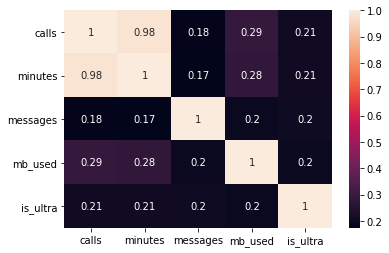

In [9]:
# взглянем на корреляцию признаков

sns.heatmap(df.corr(), annot=True);

Видно, что число звонков и суммарная длительность звонков в минутах очень сильно положительно связаны (0,98). По остальным признакам связи не видно.

**Вывод**

Данные выглядят хорошо. Пропусков и нерелевантных типов данных нет. Число звонков сильно связаны с минутами (0,98). Классы несбалансированы (70% пользователей «Смарт»).

## Разделение данных на выборки

Разделим данные на обучающую, валидационную и тестовую выборки в классическом соотношении 3:1:1.

In [10]:
# сначала делим на тренировочную и тестовую

df_train, df_test = train_test_split(df, test_size=0.4, random_state=12345, stratify=df['is_ultra'])

In [11]:
df_train.shape, df_test.shape

((1928, 5), (1286, 5))

In [12]:
# тестовую делим на тестовую и валидационную

df_test, df_valid = train_test_split(df_test, test_size=0.5, random_state=12345, stratify=df_test['is_ultra'])

In [13]:
df_test.shape, df_valid.shape

((643, 5), (643, 5))

In [14]:
# обучающую детим на признаки и целевой признак

features_train = df_train.drop('is_ultra', axis=1)
target_train = df_train['is_ultra']

In [15]:
# валидационную детим на признаки и целевой признак

features_valid = df_valid.drop('is_ultra', axis=1)
target_valid = df_valid['is_ultra']

In [16]:
# тестовую детим на признаки и целевой признак

features_test = df_test.drop('is_ultra', axis=1)
target_test = df_test['is_ultra']

**Вывод**

Исходные данные разделены на обучающую, валидационную и тестовую выборки в соотношении 3:1:1.

## Исследование моделей

По очереди исследуем модели классификации: дерево решений, случайный лес и логистическую регрессию. Выявим лучшую модель и лушие гиперпараметры.

**Дерево решений**

In [17]:
best_model_dt = None
best_score = 0
best_depth = 0

In [18]:
depth_list = []
train_score_list = []
valid_score_list = []

for max_depth in range(1, 11):
    model = DecisionTreeClassifier(max_depth=max_depth, \
                                    random_state=12345)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    accuracy = accuracy_score(target_valid, predictions)
    accuracy_train = accuracy_score(target_train, model.predict(features_train))
    depth_list.append(max_depth)
    valid_score_list.append(accuracy)
    train_score_list.append(accuracy_train)
    if accuracy > best_score:
        best_model_dt = model
        best_score = accuracy
        best_depth = max_depth
print('Accuracy лучшей модели на валидационной выборке:', best_score)
print('Глубина лучшей модели на валидационной выборке:', best_depth)

Accuracy лучшей модели на валидационной выборке: 0.8118195956454122
Глубина лучшей модели на валидационной выборке: 5


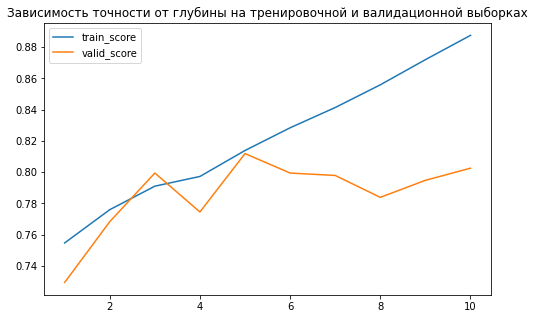

In [19]:
# простроим график зависимости точности от глубины 
# на тренировочной и валидационной выборках

fig, ax = plt.subplots()
ax.plot(depth_list, train_score_list, label = 'train_score')
ax.plot(depth_list, valid_score_list, label = 'valid_score')
ax.legend()
fig.set_figheight(5)
fig.set_figwidth(8)
plt.title('Зависимость точности от глубины на тренировочной и валидационной выборках')
plt.show();

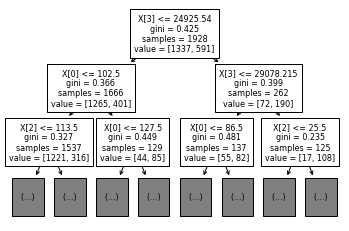

In [20]:
# проследим ход мысли модели на первых 2-х уровнях

plot_tree(best_model_dt, max_depth=2, fontsize=8);

**Случайный лес**

In [21]:
best_model_rf = None
best_score = 0
best_depth = 0
best_n_est = 0

In [22]:
%%time

depth_list = []
train_score_list = []
valid_score_list = []

for max_depth in range(1, 11):
    for est in range(1, 11):
        model = RandomForestClassifier(n_estimators=est, \
                                        max_depth=max_depth, random_state=12345)
        model.fit(features_train, target_train)
        predictions = model.predict(features_valid)
        accuracy = accuracy_score(target_valid, predictions)
        accuracy_train = accuracy_score(target_train, model.predict(features_train))
        depth_list.append(max_depth)
        valid_score_list.append(accuracy)
        train_score_list.append(accuracy_train)
        if accuracy > best_score:
            best_model_rf = model
            best_score = accuracy
            best_n_est = est
            best_depth = max_depth
print('Accuracy лучшей модели на валидационной выборке:', best_score)
print('Число деревьев лучшей модели на валидационной выборке:', best_n_est)
print('Глубина лучшей модели на валидационной выборке:', best_depth)

Accuracy лучшей модели на валидационной выборке: 0.8149300155520995
Число деревьев лучшей модели на валидационной выборке: 3
Глубина лучшей модели на валидационной выборке: 6
CPU times: user 1.9 s, sys: 15.8 ms, total: 1.91 s
Wall time: 1.92 s


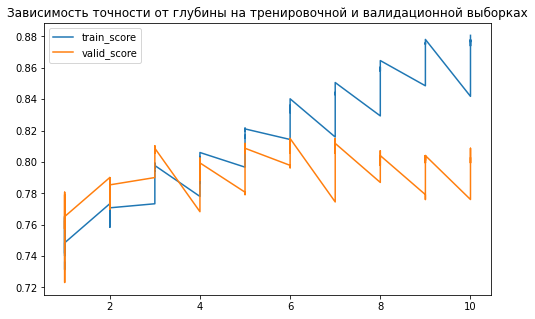

In [23]:
# простроим график зависимости точности от глубины 
# на тренировочной и валидационной выборках

fig, ax = plt.subplots()
ax.plot(depth_list, train_score_list, label = 'train_score')
ax.plot(depth_list, valid_score_list, label = 'valid_score')
ax.legend()
fig.set_figheight(5)
fig.set_figwidth(8)
plt.title('Зависимость точности от глубины на тренировочной и валидационной выборках')
plt.show();

**Логистическая регрессия**

In [24]:
model_log_reg = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000)
model_log_reg.fit(features_train, target_train)
score = model_log_reg.score(features_valid, target_valid)
print('Score модели на валидационной выборке:', score)

Score модели на валидационной выборке: 0.7465007776049767


**Вывод**

Лучше всего показала себя модель случайный лес с числом деревьев 3, глубиной 6. Доля правильных ответов на валидационной выборке 0.815. Хуже всего справилась логистическая регрессия - 0.747. Второе место у дерева решений - 0.812.

## Проверка модели на тестовой выборке

Протестируем лучшие модели (дерево решений и случайный лес с их лучшими гиперпараметрами) на тестовой выборке. Объединим тренировочную и валидационнуы выборки для большего объема данных для обучения.

In [25]:
features_train = pd.concat([features_train, features_valid], ignore_index=True)

In [26]:
target_train = pd.concat([target_train, target_valid], ignore_index=True)

In [27]:
# тестируем дерево решений

best_model_dt.fit(features_train, target_train)
predictions = best_model_dt.predict(features_test)
accuracy = accuracy_score(target_test, predictions)
print('Accuracy лучшего дерева решений на тестовой выборке:', accuracy)

Accuracy лучшего дерева решений на тестовой выборке: 0.7947122861586314


In [28]:
# тестируем случайный лес

best_model_rf.fit(features_train, target_train)
predictions = best_model_rf.predict(features_test)
accuracy = accuracy_score(target_test, predictions)
print('Accuracy лучшего случайного леса на тестовой выборке:', accuracy)

Accuracy лучшего случайного леса на тестовой выборке: 0.80248833592535


**Вывод**

Дерево - 0.79, лес - 0.8.  Выше, чем 0.75, как заявлено в целях исследования. Модель случайного леса можно считать лучшей. Для клиентов с архивными тарифами можем использовать модель случайного леса для предложения наиболее подходящего тарифа.

## Проверка моделей на адекватность

Создадим "глупую" модель со стратегией классификации 'most_frequent' и сравним ее результат с остальными.

In [29]:
dummy_model = DummyClassifier(strategy='most_frequent', random_state=12345)
dummy_model.fit(features_train, target_train)
print('Score "глупой" модели на тестовой выборке:', \
      dummy_model.score(features_test, target_test))

Score "глупой" модели на тестовой выборке: 0.6936236391912908


**Вывод**

Результат "глупой" модели (0.7) оказался хуже, чем у всех рассмотренных моделей. Можно утверждать, что все ранее рассмотренные модели адекватные.

## Общий вывод

Для подбора подходящего тарифа («Смарт» или «Ультра») для клиентов с архивными тарифами рекомендовано использовать модель случайный лес с числом деревьев 3, глубиной 6. Ее доля правильных ответов на тестовой выборке 0.8 против 0.7 на "глупой" модели. Рекомендованную модель можно считать адекватной.